In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from collections import Counter
import numpy as np
from scipy import stats

In [4]:
data = pd.read_json('../../data/processed/data.json').T

## Preprocessing  

In [5]:
nutrition_df = data[['nutrition','rating','Tags']].reset_index()

In [6]:
tags_df1 = pd.DataFrame(data['Tags']).reset_index()

In [7]:
ingredients_df1 = pd.DataFrame(data['ingredient_annotations']).reset_index()

In [8]:
geographical_tags_updated = pd.DataFrame(data['geographical_tags_updated']).reset_index()

In [9]:
nutrition_df = nutrition_df.set_index(['index','rating'])

In [10]:
nutrition_df = nutrition_df['nutrition'].apply(pd.Series)

In [11]:
nutrition_df = nutrition_df.rename(columns = {0:'Calories',1:'Fat',2:'Carbs',3:'Fiber',4:'Sugar',5:'Protein'})

In [12]:
for i in nutrition_df.columns:
    nutrition_df[i] = nutrition_df[i].str.extract('(\d+)')[0]

In [13]:
calories = [4,4,9,4,2]
nutrition_df.iloc[:,1:] = nutrition_df.iloc[:,1:].apply(pd.to_numeric, errors='coerce')
nutrition_df.iloc[:,1:] = nutrition_df.iloc[:,1:]*calories #converting nutritional values grams to their equivalent in calories
nutrition_df = nutrition_df.reset_index()
#nutrition_df = nutrition_df.dropna()
#nutrition_df = nutrition_df[nutrition_df['rating'] != 'NA']


In [14]:
nutrition_tags = pd.merge(nutrition_df,tags_df1, on = 'index',how = 'inner')

In [15]:
nutrition_tags = pd.merge(nutrition_tags,ingredients_df1, on = 'index',how = 'inner')

In [16]:
nutrition_tags = pd.merge(nutrition_tags,geographical_tags_updated,on = 'index',how = 'inner')

In [17]:
nutrition_tags['Proteins/Calories'] = nutrition_tags['Protein']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Fat/Calories'] = nutrition_tags['Fat']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Carbs/Calories'] = nutrition_tags['Carbs']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Fiber/Calories'] = nutrition_tags['Fiber']/nutrition_tags['Calories'].astype(float)
nutrition_tags['Sugar/Calories'] = nutrition_tags['Sugar']/nutrition_tags['Calories'].astype(float)

In [18]:
nutrition_tags['Tags Count'] = nutrition_tags['Tags'].apply(len)

In [19]:
nutrition_tags['Ingredients Count'] = nutrition_tags['ingredient_annotations'].apply(len)

In [20]:
nutrition_tags['Geographical Tags Count'] = nutrition_tags['geographical_tags_updated'].apply(len) 

In [21]:
#nutrition_tags = nutrition_tags[nutrition_tags['Tags Count'] <= 50]

In [22]:
dict1 = {}
for i,j in zip(nutrition_tags['Proteins/Calories'],nutrition_tags['Tags']):
    for x in j:
        dict1.setdefault(x,[]).append(i)

In [23]:
dict_mean = {}
for i,j in dict1.items():
    dict_mean[i] = (np.mean(j),len(j))

In [24]:
mean_percentage_protein = pd.DataFrame.from_dict(dict_mean,orient='index') #wrong

In [25]:
no_comments = pd.DataFrame(data['number_of_comments'].str.strip('TIPS').astype(int)).reset_index()

In [26]:
no_comments['comments_rank'] = no_comments['number_of_comments'].rank(ascending=False,method = 'first')

In [27]:
df = pd.merge(nutrition_tags,no_comments, on = 'index',how = 'inner')

In [28]:
df.loc[df['rating'] == 'NA','rating'] = np.nan

In [29]:
df['rating'] = df['rating'].apply(float)

## EDA 

In [30]:
len(df) # before dropping

2967

In [31]:
df = df[df['Geographical Tags Count'] != 0]

In [32]:
len(df) # after dropping |

2588

#### Comments

In [33]:
print(df['number_of_comments'].describe().to_latex())

\begin{tabular}{lr}
\toprule
 & number_of_comments \\
\midrule
count & 2588.000000 \\
mean & 83.824189 \\
std & 206.332644 \\
min & 0.000000 \\
25% & 6.000000 \\
50% & 26.000000 \\
75% & 88.250000 \\
max & 4704.000000 \\
\bottomrule
\end{tabular}



In [34]:
len(df[df['number_of_comments'] == 0])

226

In [35]:
df['number_of_comments'].sum() # total number of comments

216937

#### Ingredients

In [36]:
distinct_ingred = set()
for i in df['ingredient_annotations']:
    for j in i:
        distinct_ingred.add(j)

In [37]:
len(distinct_ingred) # total number of distinct ingredients

1736

In [38]:
df['Ingredients Count'].describe() # average number of ingredients per recipe

count    2588.000000
mean       13.911515
std         6.164939
min         2.000000
25%         9.000000
50%        13.000000
75%        17.000000
max        59.000000
Name: Ingredients Count, dtype: float64

#### Tags

In [39]:
distinct_tags = set()
for i in df['Tags']:
    for j in i:
        distinct_tags.add(j)

In [40]:
len(distinct_tags)

202

In [41]:
df['Tags Count'].describe() # average number of tags per recipe

count    2588.000000
mean       21.083849
std         8.284206
min         4.000000
25%        16.000000
50%        19.000000
75%        23.000000
max        90.000000
Name: Tags Count, dtype: float64

In [42]:
distinct_geo_tags = set()
for i in df['geographical_tags_updated']:
    for j in i:
        distinct_geo_tags.add(j)

In [43]:
len(distinct_geo_tags)

41

In [44]:
df['Geographical Tags Count'].describe()

count    2588.000000
mean        1.989181
std         1.368611
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max        16.000000
Name: Geographical Tags Count, dtype: float64

#### Nutritional info

In [45]:
df['Calories'].astype(float).describe() # average calories per recipe

count    2174.000000
mean      591.439282
std       329.684787
min         4.000000
25%       343.000000
50%       536.000000
75%       779.000000
max      2009.000000
Name: Calories, dtype: float64

In [46]:
df['Carbs/Calories'].describe() # average percentage of carbs in calories per recipe

count     2174.0
unique    1992.0
top          0.0
freq        15.0
Name: Carbs/Calories, dtype: float64

In [47]:
df['Fat/Calories'].describe() # average percentage of fat in calories per recipe

count     2174.0
unique    1846.0
top          0.0
freq        20.0
Name: Fat/Calories, dtype: float64

In [48]:
df['Fiber/Calories'].describe() # average percentage of fiber in calories per recipe

count     2174.0
unique    1603.0
top          0.0
freq       179.0
Name: Fiber/Calories, dtype: float64

In [49]:
df['Proteins/Calories'].describe() # average percentage of protein in calories per recipe

count     2174.0
unique    1893.0
top          0.0
freq        16.0
Name: Proteins/Calories, dtype: float64

In [50]:
df['Sugar/Calories'].describe() # average percentage of sugar in calories per recipe

count     2174.0
unique    1709.0
top          0.0
freq       107.0
Name: Sugar/Calories, dtype: float64

#### RATING

In [51]:
print(df['rating'].describe().to_latex())

\begin{tabular}{lr}
\toprule
 & rating \\
\midrule
count & 2030.000000 \\
mean & 91.747291 \\
std & 7.215249 \\
min & 21.000000 \\
25% & 90.000000 \\
50% & 94.000000 \\
75% & 96.000000 \\
max & 100.000000 \\
\bottomrule
\end{tabular}



In [52]:
df['rating']

0       98.0
1       91.0
2       96.0
3       82.0
4        NaN
        ... 
2961    96.0
2962    97.0
2963    94.0
2964     NaN
2966     NaN
Name: rating, Length: 2588, dtype: float64

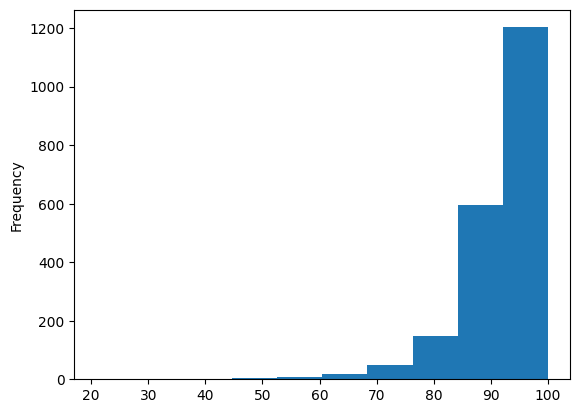

In [53]:
df['rating'].plot.hist();

In [54]:
df[df['Calories'].isna()]

,index,rating,Calories,Fat,Carbs,Fiber,Sugar,Protein,Tags,ingredient_annotations,...,Proteins/Calories,Fat/Calories,Carbs/Calories,Fiber/Calories,Sugar/Calories,Tags Count,Ingredients Count,Geographical Tags Count,number_of_comments,comments_rank
1,https://tasty.co/recipe/lauras-potato-latkes,91.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Meal, Breakfast, Sweet Breakfasts, Waffles, J...","[potato, onion, egg, salt, pepper, matzo, vege...",...,NaN,NaN,NaN,NaN,NaN,31,9,2,25,1436.0
3,https://tasty.co/recipe/green-sauce-shrimp-pasta,82.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Meal, Dinner, Seafood, Pasta, Low-Fat, Low-Su...","[butter, thyme, rosemary, shrimp, flour, milk,...",...,NaN,NaN,NaN,NaN,NaN,20,15,1,67,844.0
8,https://tasty.co/recipe/grilled-sausage-dinner...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Cuisine, European, Italian, Pasta, Meal, Stov...","[salt, sam ’s, potato gnocchi, sam ’s, basil p...",...,NaN,NaN,NaN,NaN,NaN,13,8,2,1,2547.0
9,https://tasty.co/recipe/chicken-bacon-ranch-sa...,92.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Meal, Lunch, Sandwiches, Chicken, Bread, New ...","[bacon, frank, bread, egg, chicken, ranch, che...",...,NaN,NaN,NaN,NaN,NaN,29,11,1,89,686.0
10,https://tasty.co/recipe/beet-gnocchi,78.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Cuisine, European, Italian, Pasta, High-Fiber...","[beet, potato, egg, cheese, salt, wheat flour,...",...,NaN,NaN,NaN,NaN,NaN,18,8,2,83,724.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,https://tasty.co/recipe/chicken-wings-the-gold...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Meal, Dinner, Chicken, Sliders, Dips, Under 1...","[chicken, salt, pepper, great value ® parmesan...",...,NaN,NaN,NaN,NaN,NaN,19,7,1,1,2701.0
2917,https://tasty.co/recipe/ultimate-italian-frittata,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Cuisine, European, Italian, Quiches, Egg Brea...","[potato, onion, pepper, mushroom, olive oil, b...",...,NaN,NaN,NaN,NaN,NaN,22,16,2,0,2959.0
2925,https://tasty.co/recipe/prawn-paste-chicken-ha...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Cuisine, Asian, Chinese, Chicken, Under 1 Hou...","[chicken, shrimp sauce, oyster sauce, sugar, s...",...,NaN,NaN,NaN,NaN,NaN,18,15,2,3,2445.0
2939,https://tasty.co/recipe/chicken-alfredo-lasagna,98.0,NaN,NaN,NaN,NaN,NaN,NaN,"[Meal, Dinner, Pasta, Baked Pasta, Chicken, Hi...","[chicken, salt, pepper, garlic, canola oil, ga...",...,NaN,NaN,NaN,NaN,NaN,23,13,2,168,337.0


## Separate DFs

In [55]:
ingredients = [j for i in df['ingredient_annotations'] for j in i]

In [56]:
ingredients_df = pd.DataFrame.from_dict(dict(Counter(ingredients)),orient = 'index').rename(columns = {0:'Count'}).sort_values(by='Count',ascending = False)

In [57]:
tags = [j for i in df['Tags'] for j in i]

In [58]:
tags_df = pd.DataFrame.from_dict(dict(Counter(tags)),orient = 'index').rename(columns = {0:'Count'}).sort_values(by='Count',ascending = False)

In [59]:
geo_tags = [j for i in df['geographical_tags_updated'] for j in i]

In [60]:
geo_tags_df = pd.DataFrame.from_dict(dict(Counter(geo_tags)),orient = 'index').rename(columns = {0:'Count'}).sort_values(by='Count',ascending = False)